In [1]:
# test realtime pose CLASSIFICATION (and hence landmark detection...)
# on our curated dataset of pose videos

import sys
sys.path.insert(0, '/Users/alejandraduran/Documents/Pton_courses/COS429/COS429_final_project/training_pipeline')
import os
import cv2
import mediapipe as mp
import pickle
from extract_features import FeaturesMP
import numpy as np
import time
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
from collections import Counter

# Retrieve pre-trained model
mp_model_path = "/Users/alejandraduran/Documents/Pton_courses/COS429/COS429_final_project/pretrained_models/pose_landmarker_full.task"
# Initialize FeaturesMP object
features_mp = FeaturesMP(mp_model_path, image_size=(1080, 1920))
# load the label encoder
with open('/Users/alejandraduran/Documents/Pton_courses/COS429/COS429_final_project/training_pipeline/label_encoder.pkl', 'rb') as f:    
    label_encoder = pickle.load(f)

# NOT SURE IF 7 OR 8 BUT ONE OF THOSE
# load the trained classifier
with open('/Users/alejandraduran/Documents/Pton_courses/COS429/COS429_final_project/trained_classifiers/padded_nn_7.pkl', 'rb') as f:
    classifier = pickle.load(f)
    
# load the sanskrit to english dictionary
with open('/Users/alejandraduran/Documents/Pton_courses/COS429/COS429_final_project/sanskrit_english_dict.pkl', 'rb') as f:
    sanskrit_english_dict = pickle.load(f)


# function to write demonstration videos - rest of testing function is sent in test_video.py

def test_video(video_path, features_mp, label_encoder, classifier, sanskrit_english_dict):

    cap = cv2.VideoCapture(video_path)

    frame_rate = cap.get(cv2.CAP_PROP_FPS)
    n = -1

    # introduce delay in position predictions
    buffer = [-1,-1,-1,-1]

    label_across_frames = []
    label_with_delays = []

    # Initialize detector
    features_mp.init_detector(video=True, min_pose_detection_confidence=0.7)

    # Create a loop to read the latest frame from the camera
    while cap.isOpened():
        ret, frame = cap.read()
        
        if not ret:
            print("Error: Unable to fetch the frame or finished the video.")
            break
        
        # new frame
        n+=1
        # get timestamp from frame rate
        timestamp = int(n * 1000 / frame_rate)

        # Run inference on the image 
        landmarks = features_mp.detect(frame, video=True, frame_timestamp_ms=timestamp)
        
        # Draw landmarks if detected
        if landmarks is not None:
            if len(landmarks.pose_landmarks) != 0:
                
                pose_landmarks_list = landmarks.pose_landmarks 

                # get only normalized coordinates - improves latency
                pose_landmarks = pose_landmarks_list[0]

                to_classify = np.zeros((features_mp.n_landmarks, 4))
                to_extend = []
                
                # store normalized landmarks to appends and classify
                for k, landmark in enumerate(pose_landmarks):
                    to_classify[k] = [landmark.x, landmark.y, landmark.z, landmark.visibility]
                    
                # normalize and rotate to_classify
                to_classify = features_mp.make_rot_invariant_partial(to_classify, init_norm=True)
                to_classify = to_classify.reshape(1, features_mp.n_landmarks * 4)
                    
                # Run inference
                predicted_class = classifier.predict(to_classify)
                # Get the string label
                predicted_name = label_encoder.inverse_transform([int(predicted_class-1)])
                english = sanskrit_english_dict[predicted_name[0]]
                label_across_frames.append(english)
                # Append to buffer
                buffer.pop(0)
                buffer.append(predicted_name[0])
                # # if all elements now in the buffer are the same, then we can display the pose
                if buffer[0] == buffer[1] == buffer[2] == buffer[3]:
                    text = english
                    label_with_delays.append(english)

    # Release resources
    cap.release()
    # out.release()
    cv2.destroyAllWindows()
    
    return label_across_frames, label_with_delays


In [ ]:

# MISSING ARDHA MATS, ardha pincha, ashta chandra

testing_now = ['Adho Mukha Svanasana', 'Adho Mukha Vrksasana', 'Anjaneyasana', 'Ardha Navasana','Baddha Konasana']
    
for pose in testing_now:
    label_accross_frames_list = []
    label_with_delays_list = []
    directory_path = f"/Users/alejandraduran/Documents/Pton_courses/COS429/video_data/{pose}"
    # iterate over the videos of the directory
    for dirname, _, filenames in os.walk(directory_path):
        for filename in filenames:
            if not filename.endswith(('.mp4', '.avi')):  # Only process video files
                continue  # Skip non-video files
            video_path = os.path.join(dirname, filename)
            label_across_frames, label_with_delays = test_video(video_path, features_mp, label_encoder, classifier, sanskrit_english_dict)
            label_accross_frames_list.append(label_across_frames)
            label_with_delays_list.append(label_with_delays)
            
    # save the multi-video results for each pose
    with open(f'/Users/alejandraduran/Documents/Pton_courses/COS429/COS429_final_project/testing/metrics/{pose}_label_across_frames.pkl', 'wb') as f:
        pickle.dump(label_accross_frames_list, f)
    with open(f'/Users/alejandraduran/Documents/Pton_courses/COS429/COS429_final_project/testing/metrics/{pose}_label_with_delays.pkl', 'wb') as f:
        pickle.dump(label_with_delays_list, f) 
        
    # run in cluster
            

In [ ]:
# this took 3 hours to run

import os
import pickle

# Define the base directory path
base_directory_path = "/Users/alejandraduran/Documents/Pton_courses/COS429/video_data"

# Iterate over all directories and files in the base directory
for dirname, _, filenames in os.walk(base_directory_path):
    pose = os.path.basename(dirname)
    label_accross_frames_list = []
    label_with_delays_list = []
    
    for filename in filenames:
        if not filename.endswith(('.mp4', '.avi')):  # Only process video files
            continue  # Skip non-video files
        video_path = os.path.join(dirname, filename)
        label_across_frames, label_with_delays = test_video(video_path, features_mp, label_encoder, classifier, sanskrit_english_dict)
        label_accross_frames_list.append(label_across_frames)
        label_with_delays_list.append(label_with_delays)
        
    print(f"Pose: {pose}")
    
    # Save the multi-video results for each pose
    if label_accross_frames_list and label_with_delays_list:  # Ensure there are results to save
        with open(f'/Users/alejandraduran/Documents/Pton_courses/COS429/COS429_final_project/testing/metrics/{pose}_label_across_frames.pkl', 'wb') as f:
            pickle.dump(label_accross_frames_list, f)
        with open(f'/Users/alejandraduran/Documents/Pton_courses/COS429/COS429_final_project/testing/metrics/{pose}_label_with_delays.pkl', 'wb') as f:
            pickle.dump(label_with_delays_list, f)

In [67]:
import os
import pickle
from collections import Counter
import pandas as pd

# create dataframe with the columns: pose (true label), mode_label, true_label_proportion, mode_label_proportion, number different labels
# match_score = 1 if mode label == true label, 0 otherwise: ideal all samples have match_score = 1
# true_label_proportion = number of true labels / total number of labels
# mode_label_proportion = number of mode labels / total number of labels
# number_different_labels = number of different labels
# std_dev_different_labels = standard deviation of the number of different labels

# load the snaskrit english dictionary
with open('/Users/alejandraduran/Documents/Pton_courses/COS429/COS429_final_project/sanskrit_english_dict.pkl', 'rb') as f:
    sanskrit_english_dict = pickle.load(f)

def run_stats(list_of_labels, true_label):
    # translate true_label from sanskrit to the english used in featurization
    true_label_english = sanskrit_english_dict[true_label]
    match_score = 0
    num_different_labels = np.zeros(len(list_of_labels))
    true_label_proportion = 0
    mode_label_proportion = 0
    mode_labels = []
    for i, labels in enumerate(list_of_labels):
        # create a counter
        counter = Counter(labels)
        # get the most common label, check if there are labels
        if len(counter) > 1:
            mode_label = counter.most_common(1)[0][0]
            mode_labels.append(mode_label)
            # second most common
            second_mode_label = counter.most_common(2)[1][0]
            # do the english names match?
            if mode_label == true_label_english or second_mode_label == true_label_english:
                match_score += 1.1
            # calculate the proportions
            true_label_proportion += counter[true_label_english] / len(labels)
            mode_label_proportion += counter.most_common(1)[0][1] / len(labels)
            num_different_labels[i] = len(counter)
    # get mode of modes
    if len(mode_labels) > 0:
        mode_label = Counter(mode_labels).most_common(1)[0][0]
    else:
        mode_label = true_label_english
        
    return true_label_english, mode_label, match_score/len(list_of_labels), true_label_proportion/len(list_of_labels), mode_label_proportion/len(list_of_labels), np.mean(num_different_labels), np.std(num_different_labels)


def load_and_analyze_metrics(metrics_folder):
    
    df_all = pd.DataFrame(columns=['pose', 'mode', 'match_score', 'true_label_proportion', 'mode_label_proportion', 'number_different_labels', 'std_dev_different_labels'])
    df_delay = pd.DataFrame(columns=['pose', 'mode', 'match_score', 'true_label_proportion', 'mode_label_proportion', 'number_different_labels', 'std_dev_different_labels'])

    # Iterate over the files in the metrics folder
    for filename in os.listdir(metrics_folder):
        pose = filename.split('_')[0]
        index = len(df_all)
        
        if filename.endswith('_label_across_frames.pkl'):
            file_path = os.path.join(metrics_folder, filename)
            with open(file_path, 'rb') as f:
                all_frames = pickle.load(f)   # this is a list of lists - each element is a vieo
                # calculate the statistics
                pose, mode, match_score, true_label_proportion, mode_label_proportion, number_different_labels, std_dev_different_labels = run_stats(all_frames, pose)
                # add a row to the dataframe
                df_all.loc[index] = [pose, mode, match_score, true_label_proportion, mode_label_proportion, number_different_labels, std_dev_different_labels]
                
        index_delay = len(df_delay)
        if filename.endswith('_label_with_delays.pkl'):
            file_path = os.path.join(metrics_folder, filename)
            with open(file_path, 'rb') as f:
                with_delays = pickle.load(f)
                # calculate the statistics
                pose, mode, match_score, true_label_proportion, mode_label_proportion, number_different_labels, std_dev_different_labels = run_stats(with_delays, pose)
                # add a row to the dataframe
                df_delay.loc[index_delay] = [pose, mode, match_score, true_label_proportion, mode_label_proportion, number_different_labels, std_dev_different_labels]

    return df_all, df_delay

metrics_folder = '/Users/alejandraduran/Documents/Pton_courses/COS429/COS429_final_project/testing/metrics'

df_all, df_delay = load_and_analyze_metrics(metrics_folder)

print(df_delay)

# save the dfs
df_all.to_csv('/Users/alejandraduran/Documents/Pton_courses/COS429/COS429_final_project/testing/metrics/all_metrics.csv')
df_delay.to_csv('/Users/alejandraduran/Documents/Pton_courses/COS429/COS429_final_project/testing/metrics/delay_metrics.csv')



                              pose                            mode  \
0              Seated Forward Bend                          Pigeon   
1                            Camel                           Camel   
2                       Side Plank                      Side Plank   
3                        Low Lunge                      High Lunge   
4                    Forearm Stand                 Reverse Warrior   
5              Downward-facing dog             Downward-facing dog   
6                      King Pigeon                     King Pigeon   
7                         Triangle                        Triangle   
8                              Cat                          Sphinx   
9                            Wheel                           Wheel   
10                         Dolphin             Downward-facing dog   
11                         Pyramid                         Pyramid   
12                       Warrior I                      High Lunge   
13                  

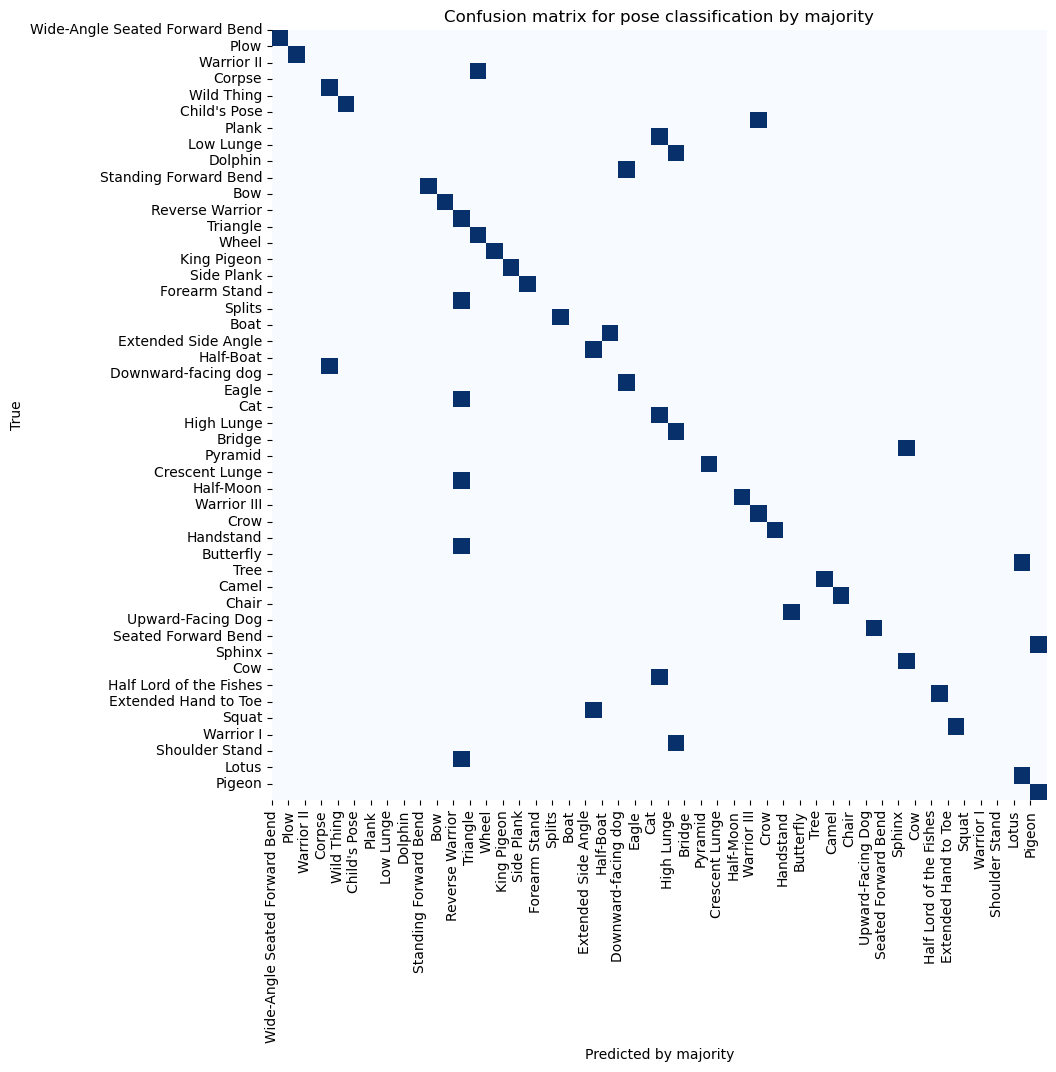

In [73]:
# plot a confusion matrix based on the pose and mode column labels

import seaborn as sns
import matplotlib.pyplot as plt

# matrix with len(df) x len(df), with ones on the value of the mode for each pose
confusion_matrix = np.zeros((len(df_all), len(df_all)))
for i in range(len(df_all)):
    for j in range(len(df_all)):
        if df_all['mode'][i] == df_all['pose'][j]:
            confusion_matrix[i,j] = 1

plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix, annot=False, cmap='Blues', cbar=False)
plt.xlabel('Predicted by majority')
plt.ylabel('True')
# put the english names on the x and y ticks
plt.xticks(ticks=np.arange(len(df_all)), labels=df_all['pose'], rotation=90)
plt.yticks(ticks=np.arange(len(df_all)), labels=df_all['pose'], rotation=0)
plt.title('Confusion matrix for pose classification by majority')
plt.show()


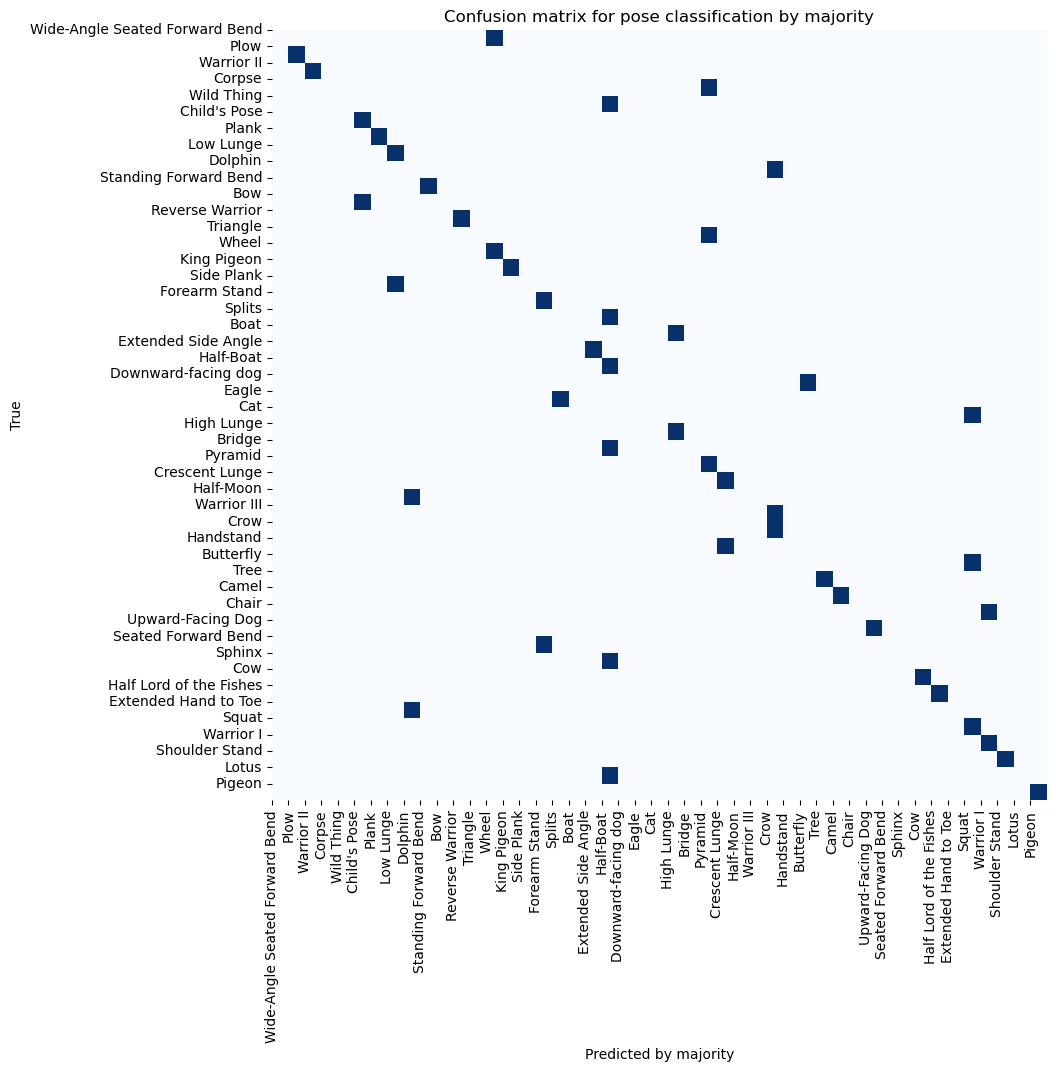

In [71]:
# plot a confusion matrix based on the pose and mode column labels
# FOR DELAY

# matrix with len(df) x len(df), with ones on the value of the mode for each pose
confusion_matrix = np.zeros((len(df_delay), len(df_delay)))
for i in range(len(df_delay)):
    for j in range(len(df_delay)):
        if df_delay['mode'][i] == df_delay['pose'][j]:
            confusion_matrix[i,j] = 1

plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix, annot=False, cmap='Blues', cbar=False)
plt.xlabel('Predicted by majority')
plt.ylabel('True')
# put the english names on the x and y ticks
plt.xticks(ticks=np.arange(len(df_all)), labels=df_all['pose'], rotation=90)
plt.yticks(ticks=np.arange(len(df_all)), labels=df_all['pose'], rotation=0)
plt.title('Confusion matrix for pose classification by majority')
plt.show()

In [46]:
# drop false counts
df_all = df_all[df_all['match_score'] != 0.0]
# get the average along the match score column - but don't consider matches of zero
print(df_all['match_score'].mean())
print(df_all['true_label_proportion'].mean())
print(df_all['std_dev_different_labels'].mean())

0.5068571428571428
0.2818064732576336
3.306499870944251


In [47]:
# drop false counts
df_delay = df_delay[df_delay['match_score'] != 0.0]
# get the average along the match score column - but don't consider matches of zero
print(df_delay['match_score'].mean())
print(df_delay['true_label_proportion'].mean())
print(df_delay['std_dev_different_labels'].mean())

0.4875510204081632
0.27569858557581683
1.7775082818735501


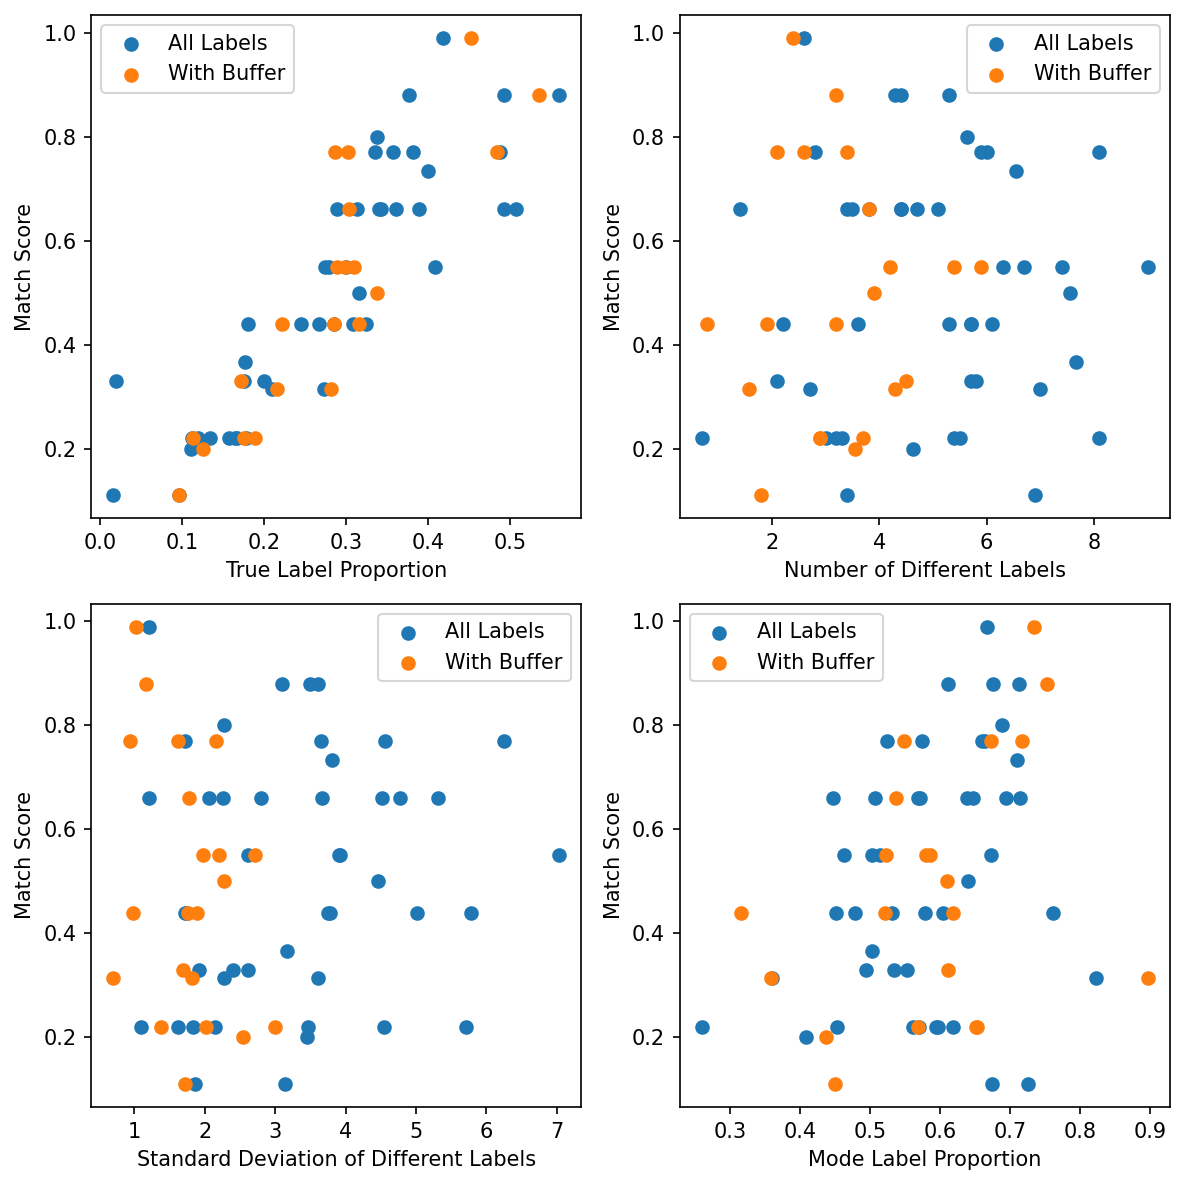

0.872012443880896


In [55]:
import matplotlib.pyplot as plt

# Create a figure with 3 subplots arranged in 1 row and 3 columns
fig, axs = plt.subplots(2, 2, figsize=(8,8), dpi=150)

# First subplot
axs[0,0].scatter(df_all['true_label_proportion'], df_all['match_score'], label='All Labels')
axs[0,0].scatter(df_delay['true_label_proportion'], df_delay['match_score'], label='With Buffer')
axs[0,0].set_xlabel('True Label Proportion')
axs[0,0].set_ylabel('Match Score')
axs[0,0].legend()

# Second subplot
axs[0,1].scatter(df_all['number_different_labels'], df_all['match_score'], label='All Labels')
axs[0,1].scatter(df_delay['number_different_labels'], df_delay['match_score'], label='With Buffer')
axs[0,1].set_xlabel('Number of Different Labels')
axs[0,1].set_ylabel('Match Score')
axs[0,1].legend()

# Third subplot
axs[1,0].scatter(df_all['std_dev_different_labels'], df_all['match_score'], label='All Labels')
axs[1,0].scatter(df_delay['std_dev_different_labels'], df_delay['match_score'], label='With Buffer')
axs[1,0].set_xlabel('Standard Deviation of Different Labels')
axs[1,0].set_ylabel('Match Score')
axs[1,0].legend()

axs[1,1].scatter(df_all['mode_label_proportion'], df_all['match_score'], label='All Labels')
axs[1,1].scatter(df_delay['mode_label_proportion'], df_delay['match_score'], label='With Buffer')
axs[1,1].set_xlabel('Mode Label Proportion')
axs[1,1].set_ylabel('Match Score')
axs[1,1].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# get correlation between match score and true label proportion
print(df_all['match_score'].corr(df_all['true_label_proportion']))

In [ ]:
# NEED TO PROCESS DATA DIFFERENTLY TO GET THE RIGHT CONFUSION MATRIX